[[2 1 0 0 1 2]
 [0 0 1 2 0 0]
 [0 2 1 0 0 2]
 [0 0 0 0 0 1]
 [0 0 1 2 0 0]
 [2 1 0 0 0 0]] 0
7.582988739013672


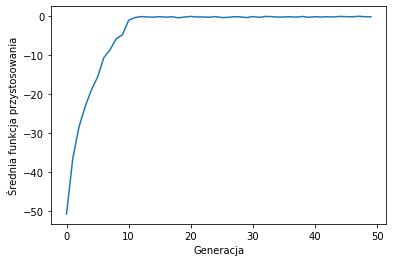

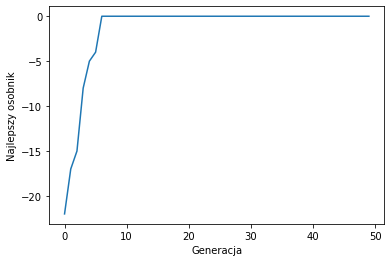

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import random
import time

start_time = time.time()
# Define the puzzle grid and clues

puzzle = np.array([
    [0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]
])

row_clues = [2, 1, 2, 0, 1, 1]
col_clues = [2, 1, 0, 2, 0, 2]

def get_neighbors(matrix, i, j):
    neighbors = []

    # Sprawdzanie sąsiadów pionowych i poziomych
    if i - 1 >= 0:
        neighbors.append((i - 1, j))  # Sąsiad powyżej
    if i + 1 < matrix.shape[0]:
        neighbors.append((i + 1, j))  # Sąsiad poniżej
    if j - 1 >= 0:
        neighbors.append((i, j - 1))  # Sąsiad po lewej
    if j + 1 < matrix.shape[1]:
        neighbors.append((i, j + 1))  # Sąsiad po prawej

    return neighbors

# Genetic Algorithm Parameters
population_size = 400
mutation_rate = 0.02
generations = 50

def initialize_population(puzzle):
    pop = []
    for _ in range(population_size):
        modified_puzzle = puzzle.copy()
        zera = np.argwhere(modified_puzzle == 0)
        jedynki = np.argwhere(modified_puzzle == 1)
        indeksy_dwojek = np.random.choice(len(zera), size=len(jedynki), replace=False)
        for indeks_dwojki, indeks_jedynki in zip(indeksy_dwojek, jedynki):
            modified_puzzle[tuple(zera[indeks_dwojki])] = 2

        pop.append(modified_puzzle)

    return pop

def fitness(solution):
    fitness = 0

    # Check row clues
    for i in range(len(row_clues)):
        row = solution[i, :]
        tent_count = np.sum(row == 2)
        if tent_count != row_clues[i]:
            fitness -= abs(row_clues[i] - tent_count)
        if tent_count == row_clues[i]:
            fitness += 1

    # Check column clues
    for j in range(len(col_clues)):
        col = solution[:, j]
        tent_count = np.sum(col == 2)
        if tent_count != col_clues[j]:
            fitness -= abs(col_clues[j] - tent_count)
        if tent_count == col_clues[j]:
            fitness += 1


    # Check vertical neighbors
    for i in range(solution.shape[0] - 1):
        for j in range(solution.shape[1]):
            if solution[i, j] == 2 and solution[i + 1, j] == 2:
                fitness -= 1

    # Check horizontal neighbors
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1] - 1):
            if solution[i, j] == 2 and solution[i, j + 1] == 2:
                fitness -= 1

    # Check diagonal neighbors (upper left to lower right)
    for i in range(solution.shape[0] - 1):
        for j in range(solution.shape[1] - 1):
            if solution[i, j] == 2 and solution[i + 1, j + 1] == 2:
                fitness -= 1

    # Check diagonal neighbors (upper right to lower left)
    for i in range(solution.shape[0] - 1):
        for j in range(1, solution.shape[1]):
            if solution[i, j] == 2 and solution[i + 1, j - 1] == 2:
                fitness -= 1
                
                
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if (solution[i, j] == 2):
                has_neighbor_one = False
                for var in get_neighbors(solution,i,j):
                    neighbor_value = solution[var[0], var[1]]
                    if neighbor_value == 1:
                        has_neighbor_one = True
                        break
                if not has_neighbor_one:
                    fitness -= 5
                    
            if (solution[i, j] == 1):
                has_neighbor_two = False
                for var in get_neighbors(solution,i,j):
                    neighbor_value = solution[var[0], var[1]]
                    if neighbor_value == 2:
                        has_neighbor_two = True
                        break
                if not has_neighbor_two:
                    fitness -= 5
    
    return fitness-solution.shape[1]-solution.shape[0]

def mutate(solution):
    # Find the indices where the value is 2
    twos_indices = np.argwhere(solution == 2)

    if len(twos_indices) > 0:
        # Randomly select one position with the value 2
        selected_index = np.random.choice(len(twos_indices))
        selected_position = twos_indices[selected_index]

        # Set the current position to 0
        solution[selected_position[0], selected_position[1]] = 0

        # Find indices where the value is 0
        zeros_indices = np.argwhere(solution == 0)

        if len(zeros_indices) > 0:
            # Randomly select one position with the value 0
            new_index = np.random.choice(len(zeros_indices))
            new_position = zeros_indices[new_index]

            # Set the new position to 2
            solution[new_position[0], new_position[1]] = 2

    return solution

def crossover(parent1, parent2):
    # Apply crossover to two parents to generate a child
    crossover_point = np.random.randint(puzzle.shape[1])
    child = np.hstack((parent1[:, :crossover_point], parent2[:, crossover_point:]))
    return child

def genetic_algorithm():
    population = initialize_population(puzzle)
    scores = [fitness(solution) for solution in population]
    best_solution_index = np.argmax(scores)
    best_solution = population[best_solution_index]
    best_score = fitness(best_solution)
    fitness_progress = []
    best_solution_progress = []

    for generation in range(generations):
        # Evaluate fitness for each solution in the population
        scores = [fitness(solution) for solution in population]
        best_solution_index = np.argmax(scores)
        best_solution = population[best_solution_index]
        best_score = fitness(best_solution)
        best_solution_progress.append(best_score)
        pop_sorted = sorted(population, key=fitness, reverse=True)
        pop_best = pop_sorted[:100]
        new_pop = pop_best.copy()

        while len(new_pop) != len(population):
            child = crossover(choice(pop_best),choice(pop_best))
            if np.random.rand() <= mutation_rate:
                    child = mutate(child)
            new_pop.append(child)

        population = new_pop
        mean_score = sum(scores)/population_size
        fitness_progress.append(mean_score)

    print(best_solution, best_score)
    plt.figure(1)
    plt.plot(fitness_progress)
    plt.xlabel('Generacja')
    plt.ylabel('Średnia funkcja przystosowania')
    plt.savefig('wykres.png')

    plt.figure(2)
    plt.plot(best_solution_progress)
    plt.xlabel('Generacja')
    plt.ylabel('Najlepszy osobnik')
    plt.savefig('wykres2.png')

if __name__ == "__main__":
    genetic_algorithm()
    
end_time = time.time()
duration = end_time - start_time
print(duration)